<center>

<h1>Final Assessment - Advanced Natural Language Processing</h1>

<i>

Course: 22DM015 Advanced Methods in Natural Language Processing <br>

Author(s): Ferran Boada Bergadà, Julián Romero, Lucia Sauer, Moritz Peist<br>

Programme: DSDM

<hr>

....

</i>

</center>

<hr>

## Setup

In [ ]:
# Imports
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import os

from transformers import (
    AutoModelForMaskedLM,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
from tqdm.notebook import tqdm
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import StratifiedShuffleSplit
import torch
from torch.utils.data import Dataset
import numpy as np

In [ ]:
# Global constants
DATA_PATH = "../data/"
SPLITS = {
    "train": "patent/train-00000-of-00001.parquet",
    "validation": "patent/validation-00000-of-00001.parquet",
    "test": "patent/test-00000-of-00001.parquet",
}
RANDOM_SEED = 42

LABELS = {
    0: "Human Necessities",
    1: "Performing Operations; Transporting",
    2: "Chemistry; Metallurgy",
    3: "Textiles; Paper",
    4: "Fixed Constructions",
    5: "Mechanical Engineering; Lighting; Heating; Weapons; Blasting",
    6: "Physics",
    7: "Electricity",
    8: "General tagging of new or cross-sectional technology",
}

In [ ]:
try:
    import google.colab

    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("Running in Google Colab")
else:
    print("Not running in Google Colab")

Running in Google Colab


## Data Load

In [ ]:
# Data loading and persistence


def load_split(
    split_name, split_path, data_path="../data", dataset="ccdv/patent-classification"
):
    """
    Load a specific split of the dataset, checking for local cache first.
    If the split is not cached locally, it will be downloaded and saved.
    Args:
        split_name (str): Name of the split (e.g., 'train', 'validation', 'test').
        split_path (str): Path to the split file in the dataset.
        data_path (str): Local path where the dataset is cached.
        dataset (str): Name of the dataset on Hugging Face Hub.
    Returns:
        pd.DataFrame: DataFrame containing the split data.
    """
    local_path = os.path.join(data_path, split_path)
    if os.path.exists(local_path):
        return pd.read_parquet(local_path)

    # Download and cache
    os.makedirs(os.path.dirname(local_path), exist_ok=True)
    df = pd.read_parquet(f"hf://datasets/{dataset}/{split_path}")
    df.to_parquet(local_path, index=False)
    return df

In [ ]:
df_train = load_split("train", SPLITS["train"])
df_validation = load_split("validation", SPLITS["validation"])
df_test = load_split("test", SPLITS["test"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Part 1

## Part 2

Here we load a BERT model trained by Google on patents.

In [ ]:
# Loading a bert model directly
model = AutoModelForMaskedLM.from_pretrained("anferico/bert-for-patents")

config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.38G [00:00<?, ?B/s]

Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### a. BERT Model with Limited Data (0.5 points):
Train a BERT-based model using only 32 labeled examples and assess its performance.

In [ ]:
# Get the 32 subsample of the training set, ensuring stratification
# sss = StratifiedShuffleSplit(n_splits=1, train_size=32, random_state=RANDOM_SEED)
# train_idx, _ = next(sss.split(df_train, df_train["label"]))
# df_train32 = df_train.iloc[train_idx]


def create_balanced_few_shot_sample(df_train, total_samples=32, random_state=42):
    """
    Create balanced few-shot dataset ensuring all classes are represented.
    """
    n_classes = df_train["label"].nunique()
    base_samples_per_class = total_samples // n_classes
    extra_samples = total_samples % n_classes

    balanced_samples = []

    for class_idx in sorted(df_train["label"].unique()):
        class_data = df_train[df_train["label"] == class_idx]

        # Calculate samples for this class
        samples_for_class = base_samples_per_class
        if class_idx < extra_samples:
            samples_for_class += 1

        # Sample from this class
        if len(class_data) >= samples_for_class:
            sampled = class_data.sample(n=samples_for_class, random_state=random_state)
        else:
            sampled = class_data  # Use all available if not enough

        balanced_samples.append(sampled)

    return (
        pd.concat(balanced_samples, ignore_index=True)
        .sample(frac=1, random_state=random_state)
        .reset_index(drop=True)
    )


df_train32 = create_balanced_few_shot_sample(
    df_train, total_samples=32, random_state=RANDOM_SEED
)

#### a.1 Tokenization

In [ ]:
# Load tokenizer for the patent BERT model
tokenizer = AutoTokenizer.from_pretrained("anferico/bert-for-patents")

vocab.txt:   0%|          | 0.00/329k [00:00<?, ?B/s]

#### a.2 Special Tokens

In [ ]:
# The tokenizer already has the special tokens configured
print("Special tokens:")
print(f"[CLS]: {tokenizer.cls_token} (ID: {tokenizer.cls_token_id})")
print(f"[SEP]: {tokenizer.sep_token} (ID: {tokenizer.sep_token_id})")
print(f"[PAD]: {tokenizer.pad_token} (ID: {tokenizer.pad_token_id})")
print(f"[UNK]: {tokenizer.unk_token} (ID: {tokenizer.unk_token_id})")

Special tokens:
[CLS]: [CLS] (ID: 2)
[SEP]: [SEP] (ID: 3)
[PAD]: [PAD] (ID: 0)
[UNK]: [UNK] (ID: 1)


#### a.3 Tokens to IDs

In [ ]:
def tokenize_function(examples):
    """Tokenize the text data"""
    return tokenizer(
        examples["text"],
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors="pt",
    )


# Tokenize the 32 training examples
train_encodings = tokenizer(
    df_train32["text"].tolist(),
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt",
)

#### a.4 Padding and Truncation

In [ ]:
# Create a custom dataset class
class PatentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {}
        for key, val in self.encodings.items():
            if torch.is_tensor(val[idx]):
                item[key] = val[idx].detach().clone()
            else:
                item[key] = torch.tensor(val[idx])
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)


# Create dataset
train_dataset = PatentDataset(train_encodings, df_train32["label"].tolist())

#### a.5 Model Setup and Training

In [ ]:
# Load model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(
    "anferico/bert-for-patents",
    num_labels=len(LABELS.items()),  # 9 patent classes
)

# Set up training arguments
training_args = TrainingArguments(
    output_dir="./results_32_samples",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=10,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=500,
    eval_strategy="no",  # No validation set for this small training
    seed=RANDOM_SEED,
    report_to=[],  # Disable all logging
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at anferico/bert-for-patents and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average="weighted", zero_division=0
    )
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

In [ ]:
# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
print("Training BERT model with 32 labeled examples...")
trainer.train()

Training BERT model with 32 labeled examples...


Step,Training Loss
10,2.219200


TrainOutput(global_step=12, training_loss=2.15783284107844, metrics={'train_runtime': 28.7496, 'train_samples_per_second': 3.339, 'train_steps_per_second': 0.417, 'total_flos': 89467526873088.0, 'train_loss': 2.15783284107844, 'epoch': 3.0})

#### a.6 Model Evaluation

In [ ]:
# Prepare validation data for evaluation
val_encodings = tokenizer(
    df_validation["text"].tolist(),
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt",
)

val_dataset = PatentDataset(val_encodings, df_validation["label"].tolist())

# Evaluate on validation set
print("Evaluating model on validation set...")
eval_results = trainer.evaluate(val_dataset)

print("\nValidation Results:")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")

Evaluating model on validation set...



Validation Results:
eval_loss: 1.9436
eval_accuracy: 0.2284
eval_f1: 0.1217
eval_precision: 0.2182
eval_recall: 0.2284
eval_runtime: 218.5631
eval_samples_per_second: 22.8770
eval_steps_per_second: 2.8600
epoch: 3.0000


#### a.7 Performance Assessment

In [ ]:
# Get predictions for analysis
predictions = trainer.predict(val_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = df_validation["label"].tolist()

In [ ]:
# Calculate per-class metrics
print("\nDetailed Classification Report:")
print(
    classification_report(
        true_labels,
        predicted_labels,
        target_names=list(LABELS.values()),
        zero_division=0,
    )
)


Detailed Classification Report:
                                                              precision    recall  f1-score   support

                                           Human Necessities       0.51      0.13      0.21       703
                         Performing Operations; Transporting       0.50      0.00      0.00       705
                                       Chemistry; Metallurgy       0.00      0.00      0.00       421
                                             Textiles; Paper       0.00      0.00      0.00        40
                                         Fixed Constructions       0.00      0.00      0.00       146
Mechanical Engineering; Lighting; Heating; Weapons; Blasting       0.00      0.00      0.00       347
                                                     Physics       0.13      0.05      0.07      1092
                                                 Electricity       0.23      0.95      0.37      1049
        General tagging of new or cross-sectiona


Confusion Matrix:

Confusion Matrix:


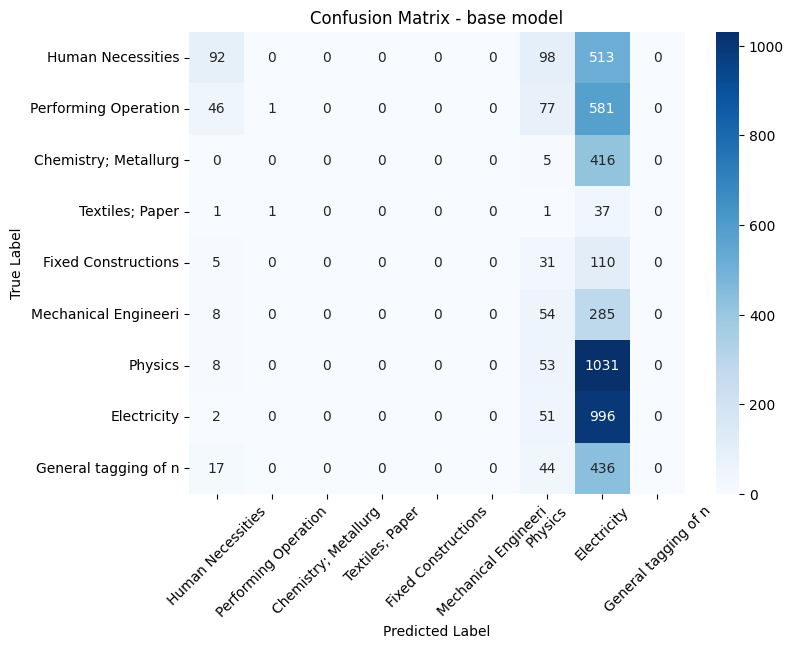

In [ ]:
print(f"\nConfusion Matrix:")
cm = confusion_matrix(true_labels, predicted_labels)
print(f"\nConfusion Matrix:")
lab = [label[:20] for label in LABELS.values()]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=lab, yticklabels=lab)
plt.xlabel("Predicted Label")
plt.xticks(rotation=45)
plt.ylabel("True Label")
plt.title("Confusion Matrix - base model")
plt.show()

In [ ]:
# Calculate baseline comparison (random classifier)
n_classes = len(LABELS)
random_accuracy = 1.0 / n_classes
print(f"\nRandom Baseline Accuracy: {random_accuracy:.4f}")
print(f"Model Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"Improvement over random: {eval_results['eval_accuracy'] - random_accuracy:.4f}")

# Performance summary
print(f"\n=== BERT Model with 32 Labeled Examples - Performance Summary ===")
print(f"Training samples: 32")
print(f"Validation accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"Validation F1-score: {eval_results['eval_f1']:.4f}")
print(f"Validation precision: {eval_results['eval_precision']:.4f}")
print(f"Validation recall: {eval_results['eval_recall']:.4f}")


Random Baseline Accuracy: 0.1111
Model Accuracy: 0.2284
Improvement over random: 0.1173

=== BERT Model with 32 Labeled Examples - Performance Summary ===
Training samples: 32
Validation accuracy: 0.2284
Validation F1-score: 0.1217
Validation precision: 0.2182
Validation recall: 0.2284


#### Interpretation of Results


...

In [ ]:
# Save baseline results for later comparison
baseline_results = {
    "accuracy": eval_results["eval_accuracy"],
    "f1": eval_results["eval_f1"],
    "precision": eval_results["eval_precision"],
    "recall": eval_results["eval_recall"],
}

with open("../data/results/baseline_results.pkl", "wb") as f:
    pickle.dump(baseline_results, f)

In [ ]:
df_results = pd.DataFrame.from_dict(baseline_results, orient="index", columns=["Base"])
df_results

,Base
accuracy,0.228400
f1,0.121729
precision,0.218160
recall,0.228400


### b. Dataset Augmentation (1 point):
Experiment with an automated technique to increase your dataset size without using LLMs (chatGPT / Mistral / Gemini / etc...). Evaluate the impact on model performance.

### b.1 Back-Translation Setup with MarianMT

In [ ]:
import time

from transformers import MarianMTModel, MarianTokenizer

# Load MarianMT models for back-translation (English <-> Spanish)
print("Loading MarianMT models for back-translation...")

# English to Spanish model
en_es_model_name = "Helsinki-NLP/opus-mt-en-es"
en_es_tokenizer = MarianTokenizer.from_pretrained(en_es_model_name)
en_es_model = MarianMTModel.from_pretrained(en_es_model_name)

# Spanish to English model
es_en_model_name = "Helsinki-NLP/opus-mt-es-en"
es_en_tokenizer = MarianTokenizer.from_pretrained(es_en_model_name)
es_en_model = MarianMTModel.from_pretrained(es_en_model_name)

print("MarianMT models loaded successfully!")

Loading MarianMT models for back-translation...


tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:177: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/312M [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

MarianMT models loaded successfully!


### b.2 Back-Translation Functions

In [ ]:
def translate_to_spanish(texts, batch_size=8):
    """Translate English texts to Spanish"""
    translated_texts = []

    # Calculate total number of batches for progress bar
    total_batches = (len(texts) + batch_size - 1) // batch_size

    for i in tqdm(
        range(0, len(texts), batch_size),
        desc="Translating EN→ES",
        total=total_batches,
        unit="batch",
    ):
        batch = texts[i : i + batch_size]

        # Tokenize and translate
        inputs = en_es_tokenizer(
            batch, return_tensors="pt", padding=True, truncation=True, max_length=512
        )
        translated = en_es_model.generate(
            **inputs, max_length=512, num_beams=4, early_stopping=True
        )

        # Decode translations
        batch_translations = en_es_tokenizer.batch_decode(
            translated, skip_special_tokens=True
        )
        translated_texts.extend(batch_translations)

    return translated_texts


def translate_to_english(texts, batch_size=8):
    """Translate Spanish texts back to English"""
    translated_texts = []

    # Calculate total number of batches for progress bar
    total_batches = (len(texts) + batch_size - 1) // batch_size

    for i in tqdm(
        range(0, len(texts), batch_size),
        desc="Translating ES→EN",
        total=total_batches,
        unit="batch",
    ):
        batch = texts[i : i + batch_size]

        # Tokenize and translate
        inputs = es_en_tokenizer(
            batch, return_tensors="pt", padding=True, truncation=True, max_length=512
        )
        translated = es_en_model.generate(
            **inputs, max_length=512, num_beams=4, early_stopping=True
        )

        # Decode translations
        batch_translations = es_en_tokenizer.batch_decode(
            translated, skip_special_tokens=True
        )
        translated_texts.extend(batch_translations)

    return translated_texts


def back_translate(texts, target_lang="es"):
    """Perform back-translation: en -> target_lang -> en"""
    print(f"Starting back-translation for {len(texts)} texts...")
    start_time = time.time()

    # Step 1: Translate to target language
    if target_lang == "es":
        intermediate = translate_to_spanish(texts)
        # Step 2: Translate back to English
        back_translated = translate_to_english(intermediate)
    else:
        raise ValueError(f"Language {target_lang} not supported. Use 'es' for Spanish.")

    end_time = time.time()
    print(f"Back-translation completed in {end_time - start_time:.2f} seconds")

    return back_translated

### b.3 Generate Augmented Dataset

In [ ]:
# Extract original texts and labels from 32-sample training set
original_texts = df_train32["text"].tolist()
original_labels = df_train32["label"].tolist()

print(f"Original training set size: {len(original_texts)}")

# Perform back-translation to create augmented samples
print("\nGenerating augmented data through back-translation...")
augmented_texts = back_translate(original_texts, target_lang="es")

# Quality check: show examples of original vs augmented texts
print("\n=== Back-Translation Examples ===")
for i in range(min(3, len(original_texts))):
    print(f"\nExample {i + 1}:")
    print(f"Original:  {original_texts[i][:200]}...")
    print(f"Augmented: {augmented_texts[i][:200]}...")

# Filter augmented texts (remove identical ones)
filtered_augmented = []
filtered_labels = []

for orig, aug, label in zip(original_texts, augmented_texts, original_labels):
    # Only keep augmented text if it's different from original
    if orig.strip().lower() != aug.strip().lower():
        filtered_augmented.append(aug)
        filtered_labels.append(label)

print(
    f"\nValid augmented samples: {len(filtered_augmented)} out of {len(augmented_texts)}"
)

# Combine original and augmented data
combined_texts = original_texts + filtered_augmented
combined_labels = original_labels + filtered_labels

print(f"Total training samples after augmentation: {len(combined_texts)}")
print(f"Data expansion factor: {len(combined_texts) / len(original_texts):.2f}x")

Original training set size: 32

Generating augmented data through back-translation...
Starting back-translation for 32 texts...


Translating EN→ES:   0%|          | 0/4 [00:00<?, ?batch/s]

model.safetensors:   0%|          | 0.00/312M [00:00<?, ?B/s]

Translating ES→EN:   0%|          | 0/4 [00:00<?, ?batch/s]

Back-translation completed in 334.84 seconds

=== Back-Translation Examples ===

Example 1:
Original:  reference will now be made in detail to the present preferred embodiments of the invention , examples of which are illustrated in the accompanying drawings . wherever possible , the same reference num...
Augmented: the reference shall now be made in detail to the current preferred incarnations of the invention , examples of which are illustrated in the attached drawings . Wherever possible , the same reference n...

Example 2:
Original:  all terms as used herein in this specification , unless otherwise stated , shall be understood in their ordinary meaning as known in the art . other more specific definitions are as follows : the term...
Augmented: all the terms used in this specification , unless otherwise stated , shall be understood in their ordinary sense as being known in art . Other more specific definitions are the following : the term “ ...

Example 3:
Original:  in the follow

### b.4 Train Model on Augmented Dataset

In [ ]:
# Prepare augmented dataset for training
augmented_encodings = tokenizer(
    combined_texts, truncation=True, padding=True, max_length=512, return_tensors="pt"
)

augmented_train_dataset = PatentDataset(augmented_encodings, combined_labels)

# Setup training for augmented model
augmented_model = AutoModelForSequenceClassification.from_pretrained(
    "anferico/bert-for-patents", num_labels=9
)

augmented_training_args = TrainingArguments(
    output_dir="./results_augmented",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=20,  # Slightly more warmup for larger dataset
    weight_decay=0.01,
    logging_dir="./logs_augmented",
    logging_steps=10,
    save_steps=500,
    eval_strategy="no",
    seed=RANDOM_SEED,
    report_to=[],  # Disable all logging, e.g. wandb
)

# Train augmented model
augmented_trainer = Trainer(
    model=augmented_model,
    args=augmented_training_args,
    train_dataset=augmented_train_dataset,
    compute_metrics=compute_metrics,
)

print("Training BERT model with back-translation augmented data...")
augmented_trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at anferico/bert-for-patents and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training BERT model with back-translation augmented data...


Step,Training Loss
10,2.209200
20,1.634900


TrainOutput(global_step=24, training_loss=1.794170121351878, metrics={'train_runtime': 36.027, 'train_samples_per_second': 5.329, 'train_steps_per_second': 0.666, 'total_flos': 178935053746176.0, 'train_loss': 1.794170121351878, 'epoch': 3.0})

### b.5 Evaluate Augmented Model

In [ ]:
# Evaluate augmented model on validation set
print("Evaluating augmented model on validation set...")
augmented_eval_results = augmented_trainer.evaluate(val_dataset)

print("\nAugmented Model Validation Results:")
for key, value in augmented_eval_results.items():
    print(f"{key}: {value:.4f}")

Evaluating augmented model on validation set...



Augmented Model Validation Results:
eval_loss: 1.8435
eval_accuracy: 0.3286
eval_f1: 0.2882
eval_precision: 0.3698
eval_recall: 0.3286
eval_runtime: 219.7026
eval_samples_per_second: 22.7580
eval_steps_per_second: 2.8450
epoch: 3.0000


### b.6 Compare Results: Baseline vs Augmented

In [ ]:
# Performance comparison
print("\n" + "=" * 60)
print("DATASET AUGMENTATION IMPACT ANALYSIS")
print("=" * 60)

print("\n📊 TRAINING DATA COMPARISON:")
print("  Baseline (32 samples):     32 samples")
print(f"  Augmented dataset:         {len(combined_texts)} samples")
print(f"  Expansion factor:          {len(combined_texts) / 32:.2f}x")

print("\n📈 PERFORMANCE COMPARISON:")
metrics = ["accuracy", "f1", "precision", "recall"]
for metric in metrics:
    baseline_val = baseline_results[metric]
    augmented_val = augmented_eval_results[f"eval_{metric}"]
    improvement = augmented_val - baseline_val
    improvement_pct = (improvement / baseline_val) * 100

    print(f"  {metric.upper()}:")
    print(f"    Baseline:     {baseline_val:.4f}")
    print(f"    Augmented:    {augmented_val:.4f}")
    print(f"    Improvement:  {improvement:+.4f} ({improvement_pct:+.1f}%)")
    print()

# Statistical significance test (simple)
accuracy_improvement = (
    augmented_eval_results["eval_accuracy"] - baseline_results["accuracy"]
)
print("🎯 KEY FINDINGS:")
print(f"  • Accuracy improvement: {accuracy_improvement:+.4f}")
if accuracy_improvement > 0.01:  # 1% threshold
    print("  • Result: SIGNIFICANT improvement with back-translation")
elif accuracy_improvement > 0:
    print("  • Result: MARGINAL improvement with back-translation")
else:
    print("  • Result: NO improvement with back-translation")

print("\n✅ AUGMENTATION TECHNIQUE ASSESSMENT:")
print("  • Back-translation with MarianMT (en→es→en)")
print(f"  • Generated {len(filtered_augmented)} valid augmented samples")
print(
    f"  • Quality: {len(filtered_augmented) / len(original_texts) * 100:.1f}% of attempts were unique"
)
print(f"  • Impact: {accuracy_improvement:+.4f} accuracy change")


DATASET AUGMENTATION IMPACT ANALYSIS

📊 TRAINING DATA COMPARISON:
  Baseline (32 samples):     32 samples
  Augmented dataset:         64 samples
  Expansion factor:          2.00x

📈 PERFORMANCE COMPARISON:
  ACCURACY:
    Baseline:     0.2284
    Augmented:    0.3286
    Improvement:  +0.1002 (+43.9%)

  F1:
    Baseline:     0.1217
    Augmented:    0.2882
    Improvement:  +0.1665 (+136.8%)

  PRECISION:
    Baseline:     0.2182
    Augmented:    0.3698
    Improvement:  +0.1516 (+69.5%)

  RECALL:
    Baseline:     0.2284
    Augmented:    0.3286
    Improvement:  +0.1002 (+43.9%)

🎯 KEY FINDINGS:
  • Accuracy improvement: +0.1002
  • Result: SIGNIFICANT improvement with back-translation

✅ AUGMENTATION TECHNIQUE ASSESSMENT:
  • Back-translation with MarianMT (en→es→en)
  • Generated 32 valid augmented samples
  • Quality: 100.0% of attempts were unique
  • Impact: +0.1002 accuracy change


In [ ]:
# Detailed analysis per class
augmented_predictions = augmented_trainer.predict(val_dataset)
augmented_pred_labels = np.argmax(augmented_predictions.predictions, axis=1)

In [ ]:
print("\n📋 DETAILED CLASSIFICATION REPORT (Augmented Model):")
print(
    classification_report(
        true_labels,
        augmented_pred_labels,
        target_names=list(LABELS.values()),
        zero_division=0,
    )
)


📋 DETAILED CLASSIFICATION REPORT (Augmented Model):
                                                              precision    recall  f1-score   support

                                           Human Necessities       0.26      0.29      0.27       703
                         Performing Operations; Transporting       0.32      0.31      0.31       705
                                       Chemistry; Metallurgy       0.58      0.44      0.50       421
                                             Textiles; Paper       0.00      0.00      0.00        40
                                         Fixed Constructions       0.00      0.00      0.00       146
Mechanical Engineering; Lighting; Heating; Weapons; Blasting       1.00      0.01      0.01       347
                                                     Physics       0.28      0.68      0.40      1092
                                                 Electricity       0.52      0.27      0.36      1049
        General tagging of n


Confusion Matrix:


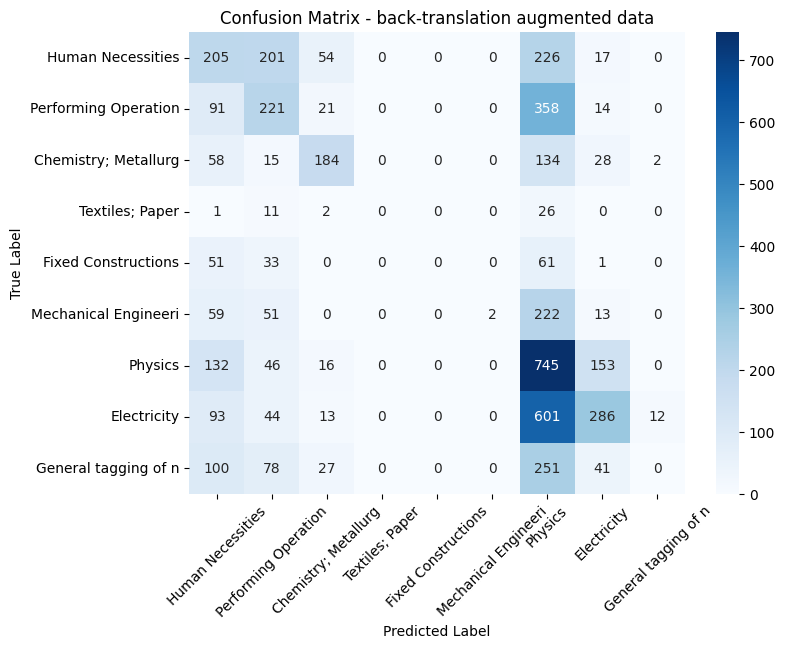

In [ ]:
print(f"\nConfusion Matrix:")
cm = confusion_matrix(true_labels, augmented_pred_labels)
lab = [label[:20] for label in LABELS.values()]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=lab, yticklabels=lab)
plt.xlabel("Predicted Label")
plt.xticks(rotation=45)
plt.ylabel("True Label")
plt.title("Confusion Matrix - back-translation augmented data")
plt.show()

In [ ]:
# Save augmented results for later comparison
augmented_results = {
    "accuracy": augmented_eval_results["eval_accuracy"],
    "f1": augmented_eval_results["eval_f1"],
    "precision": augmented_eval_results["eval_precision"],
    "recall": augmented_eval_results["eval_recall"],
}

In [ ]:
df_results = pd.concat(
    [
        df_results,
        pd.DataFrame.from_dict(augmented_results, orient="index", columns=["back-tl"]),
    ],
    axis=1,
)
df_results

,Base,back-tl
accuracy,0.228400,0.328600
f1,0.121729,0.288231
precision,0.218160,0.369785
recall,0.228400,0.328600


### c. Zero-Shot Learning with LLM (0.5 points):
Apply a LLM (chatGPT/Claude/Mistral/Gemini/...) in a zero-shot learning setup. Document the performance.

In [ ]:
# Define the system prompt for the model
system_prompt = f"""
System: You are an expert patent classifier. You will be given a patent text and you need to classify it into one of 9 categories specified below.

Disable thinking: /no_think

Task: Classify this patent text into one of the following 9 categories:
{LABELS}

Response format: {{"classification": 0, "confidence": 0.95, "reasoning": "..."}}
"""

print(system_prompt)


System: You are an expert patent classifier. You will be given a patent text and you need to classify it into one of 9 categories specified below. 

Disable thinking: /no_think

Task: Classify this patent text into one of the following 9 categories:
{0: 'Human Necessities', 1: 'Performing Operations; Transporting', 2: 'Chemistry; Metallurgy', 3: 'Textiles; Paper', 4: 'Fixed Constructions', 5: 'Mechanical Engineering; Lighting; Heating; Weapons; Blasting', 6: 'Physics', 7: 'Electricity', 8: 'General tagging of new or cross-sectional technology'}

Response format: {"classification": 0, "confidence": 0.95, "reasoning": "..."}



In [ ]:
# Here we use an open source model (Qwen3 1.7B) - a "lite-weight" LLM for smaller devices in combination with LLM studio and pydantic

from pydantic import BaseModel
import lmstudio as lms

# Load the Gemma 3 model (for this to work we first need to run `lms server start` in the terminal)
model = lms.llm(
    "qwen/qwen3-1.7b",
    config={
        "contextLength": 8096,  # Set to 8K context (this will be 7100 for input and 996 for output)
    },
)  # Load the Qwen3 1.7B model
print(lms.list_loaded_models()[0])  # Print model we are using


# Instead of using JSON structure we enforce a schema using Pydantic which we deem the more pythonic way
# A class based schema for a classification response
class PatentClassifierSchema(BaseModel):
    classification: int
    confidence: float
    reasoning: str


# Next we define a truncation function to ensure the response fits within the model's context length
def truncate_to_max_tokens(model, text, max_tokens):
    """Truncate text to fit within max_tokens limit"""

    # Count tokens in the text
    token_count = model.count_tokens(text)

    if token_count <= max_tokens:
        return text

    # If too long, truncate by estimating characters
    # Rule of thumb: ~4 characters per token for most models
    estimated_chars = max_tokens * 4

    # Truncate with some buffer
    truncated = text[:estimated_chars]

    # Verify and fine-tune
    while model.count_tokens(truncated) > max_tokens:
        # Remove 10% more characters and try again
        truncated = truncated[: int(len(truncated) * 0.9)]

    return truncated


# Here we define a method to repeatedly ask the model for a response
def respond(model, system_prompt, prompt, response_format):
    """
    Ask the model a question and get a response in the specified format.
    """

    # Get model context length
    context_length = model.get_context_length()
    # Reserve tokens for system prompt and response
    system_tokens = model.count_tokens(system_prompt)
    available_tokens = context_length - system_tokens

    # Truncate user prompt if needed
    truncated_prompt = truncate_to_max_tokens(model, prompt, available_tokens)

    # Create a chat with an initial system prompt (initialize message here to always start new chats and don't use previous context)
    chat = lms.Chat(system_prompt)
    # Build the chat context by adding messages of relevant types.
    chat.add_user_message(truncated_prompt)
    # Get the response from the model, specifying the response format.
    response = model.respond(chat, response_format=response_format)

    return response.parsed

LLM(identifier='qwen/qwen3-1.7b')


In [ ]:
# Iterate through our 32 training examples and classify them and store the results

if os.path.exists("../data/results/llm_classification_results.pkl"):
    with open("../data/results/llm_classification_results.pkl", "rb") as f:
        llm_results = pickle.load(f)
else:
    llm_results = []

    for i, text in tqdm(
        enumerate(df_train32["text"].tolist()),
        desc="Classifying patent",
        total=len(df_train32),
    ):
        classification_result = respond(
            model=model,
            system_prompt=system_prompt,
            prompt=text,
            response_format=PatentClassifierSchema,
        )
        llm_results.append(classification_result)

    # Unload model to free up memory
    model.unload()

    # Pickle results to save them for later analysis
    with open("../data/results/llm_classification_results.pkl", "wb") as f:
        pickle.dump(llm_results, f)

Classifying patent:   0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
# Evaluate the performance of the zero-shot LLM
def evaluate_llm_results(results, true_labels):
    """
    Evaluate the LLM classification results against true labels.

    Args:
        results (list): List of LLM classification results.
        true_labels (list): List of true labels for the patents.

    Returns:
        dict: Evaluation metrics including accuracy, precision, recall, and F1-score.
    """
    predictions = [result["classification"] for result in results]

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average="weighted", zero_division=0
    )

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }


llm_result_stats = evaluate_llm_results(llm_results, df_train32["label"].tolist())
print(llm_result_stats)

with open("../data/results/llm_classification_result_stats.pkl", "wb") as f:
    pickle.dump(llm_result_stats, f)

{'accuracy': 0.28125, 'precision': 0.397203947368421, 'recall': 0.28125, 'f1': 0.27529761904761907}


In [ ]:
len([result["classification"] for result in llm_results])

32

In [ ]:
df_results = pd.concat(
    [df_results, pd.DataFrame.from_dict(llm_stats, orient="index", columns=["llm"])],
    axis=1,
)
df_results

,Base,back-tl,llm
accuracy,0.228400,0.328600,0.281250
f1,0.121729,0.288231,0.275298
precision,0.218160,0.369785,0.397204
recall,0.228400,0.328600,0.281250


### d. Data Generation with LLM (1 point):
Use a LLM (chatGPT/Claude/Mistral/Gemini/...) to generate new, labeled dataset points. Train your BERT model with it + the 32 labels. Analyze how this impacts model metrics.

In [ ]:
# A class based schema for a labeled datapoint response
class PatentGeneratorSchema(BaseModel):
    text: str  # The generated patent text
    label: int  # The class label (0-8)

In [ ]:
# Generate 32 new labeled datapoints for each class - with this approach we keep the class (im)balance in the original dataset

if os.path.exists("../data/results/llm_generation_results.pkl"):
    with open("../data/results/llm_generation_results.pkl", "rb") as f:
        llm_generation_results = pickle.load(f)
else:
    llm_generation_results = []

    for i, row in tqdm(
        enumerate(df_train32.iterrows()),
        desc="Generating patents",
        total=len(df_train32),
    ):
        generation_prompt = f"""
System: You are an expert in patents.

Disable thinking: /no_think

Task: Generate a realistic patent text for class {row[1]["label"]}: {LABELS[row[1]["label"]]} similar to the input text.

Requirements:
- 100-200 words
- Technical language appropriate for patents
- Include specific technical details
- Text format: Return only the patent text, no additional formatting
- Label format: Return the label you were given as an integer (0-8)

Response format: {{"text": str, "label": 0}}
        """
        classification_result = respond(
            model=model,
            system_prompt=generation_prompt,
            prompt=row[1]["text"],
            response_format=PatentGeneratorSchema,
        )
        llm_generation_results.append(classification_result)

    # Unload model to free up memory
    model.unload()

    # Pickle results to save them for later analysis
    with open("../data/results/llm_generation_results.pkl", "wb") as f:
        pickle.dump(llm_generation_results, f)

Generating patents:   0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
# For google colab
if IN_COLAB:
    with open("data/results/llm_generation_results.pkl", "rb") as f:
        llm_generation_results = pickle.load(f)

In [ ]:
# Now we combine the generated data with the original 32 sample training set
df_train32llm = pd.concat([df_train32, pd.DataFrame(llm_generation_results)])

In [ ]:
# Prepare augmented dataset for training
llm_augmented_encodings = tokenizer(
    df_train32llm["text"].to_list(),
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt",
)

llm_augmented_train_dataset = PatentDataset(
    llm_augmented_encodings, df_train32llm["label"].to_list()
)

# Setup training for augmented model
llm_augmented_model = AutoModelForSequenceClassification.from_pretrained(
    "anferico/bert-for-patents", num_labels=9
)

llm_augmented_training_args = TrainingArguments(
    output_dir="./results_llm_augmented",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=20,  # Slightly more warmup for larger dataset
    weight_decay=0.01,
    logging_dir="./logs_llm_augmented",
    logging_steps=10,
    save_steps=500,
    eval_strategy="no",
    seed=RANDOM_SEED,
    report_to=[],  # Disable all logging, e.g. wandb
)

# Train augmented model
llm_augmented_trainer = Trainer(
    model=llm_augmented_model,
    args=llm_augmented_training_args,
    train_dataset=llm_augmented_train_dataset,
    compute_metrics=compute_metrics,
)

print("Training BERT model with back-translation augmented data...")
llm_augmented_trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at anferico/bert-for-patents and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training BERT model with back-translation augmented data...


Step,Training Loss
10,2.271600
20,1.464800


TrainOutput(global_step=24, training_loss=1.6982336441675823, metrics={'train_runtime': 40.6896, 'train_samples_per_second': 4.719, 'train_steps_per_second': 0.59, 'total_flos': 178935053746176.0, 'train_loss': 1.6982336441675823, 'epoch': 3.0})

In [ ]:
# Evaluate augmented model on validation set
print("Evaluating augmented model on validation set...")
llm_augmented_eval_results = llm_augmented_trainer.evaluate(val_dataset)

print("\nAugmented Model Validation Results:")
for key, value in llm_augmented_eval_results.items():
    print(f"{key}: {value:.4f}")

Evaluating augmented model on validation set...



Augmented Model Validation Results:
eval_loss: 1.8095
eval_accuracy: 0.3536
eval_f1: 0.3141
eval_precision: 0.3977
eval_recall: 0.3536
eval_runtime: 219.4800
eval_samples_per_second: 22.7810
eval_steps_per_second: 2.8480
epoch: 3.0000


In [ ]:
# Get predictions for analysis
llm_predictions = llm_augmented_trainer.predict(val_dataset)
llm_predicted_labels = np.argmax(llm_predictions.predictions, axis=1)
true_labels = df_validation["label"].tolist()

In [ ]:
# Calculate per-class metrics
print("\nDetailed Classification Report:")
print(
    classification_report(
        true_labels,
        llm_predicted_labels,
        target_names=list(LABELS.values()),
        zero_division=0,
    )
)


Detailed Classification Report:
                                                              precision    recall  f1-score   support

                                           Human Necessities       0.23      0.60      0.33       703
                         Performing Operations; Transporting       0.42      0.13      0.20       705
                                       Chemistry; Metallurgy       0.63      0.44      0.52       421
                                             Textiles; Paper       0.00      0.00      0.00        40
                                         Fixed Constructions       0.68      0.13      0.22       146
Mechanical Engineering; Lighting; Heating; Weapons; Blasting       0.67      0.01      0.02       347
                                                     Physics       0.36      0.61      0.45      1092
                                                 Electricity       0.52      0.35      0.42      1049
        General tagging of new or cross-sectiona


Confusion Matrix:


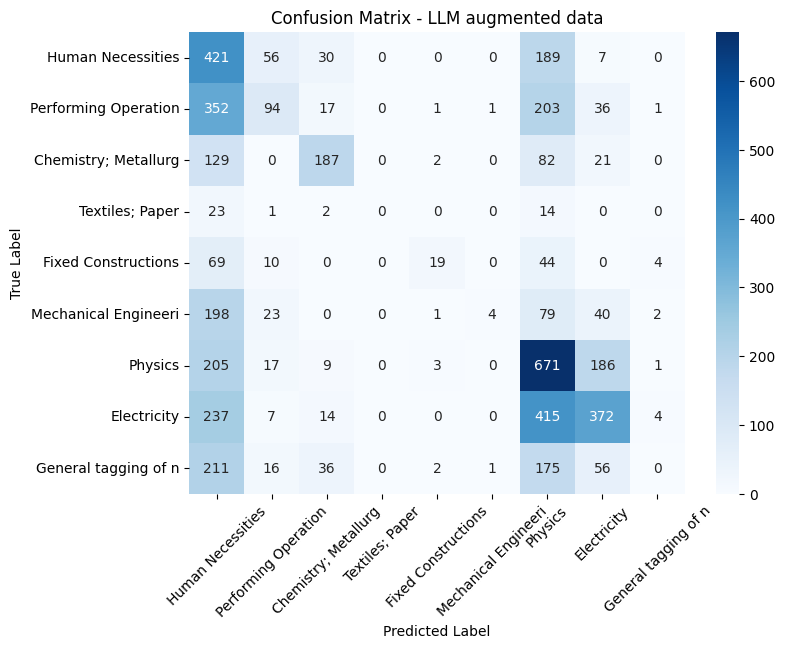

In [ ]:
print(f"\nConfusion Matrix:")
cm = confusion_matrix(true_labels, llm_predicted_labels)
lab = [label[:20] for label in LABELS.values()]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=lab, yticklabels=lab)
plt.xlabel("Predicted Label")
plt.xticks(rotation=45)
plt.ylabel("True Label")
plt.title("Confusion Matrix - LLM augmented data")
plt.show()

In [ ]:
# Save augmented results for later comparison
llm_augmented_results = {
    "accuracy": llm_augmented_eval_results["eval_accuracy"],
    "f1": llm_augmented_eval_results["eval_f1"],
    "precision": llm_augmented_eval_results["eval_precision"],
    "recall": llm_augmented_eval_results["eval_recall"],
}

with open("data/results/llm_augmented_results.pkl", "wb") as f:
    pickle.dump(llm_augmented_results, f)

In [ ]:
df_results1 = pd.concat(
    [
        df_results,
        pd.DataFrame.from_dict(
            llm_augmented_results, orient="index", columns=["LLM-data"]
        ),
    ],
    axis=1,
)
df_results1

,Base,back-tl,llm,LLM-data
accuracy,0.228400,0.328600,0.281250,0.353600
f1,0.121729,0.288231,0.275298,0.314148
precision,0.218160,0.369785,0.397204,0.397689
recall,0.228400,0.328600,0.281250,0.353600


### e. Optimal Technique Application (0.5 points):
 Based on the previous experiments, apply the most effective technique(s) to further improve your model's performance. Comment your results and propose improvements.

## Part 3

## Part 4